## ACP 166: Datos abiertos para ciudades resilientes
### Unidad 2: Datos abiertos para ciudades y clima
#### 5 de noviembre 2025

Objectives for today????

In this lesson, we will consider a range of open source datasets related to population exposure. We'll compare data from the the Argentine INDEC, GHSL, and open building footprints to attempt to estimate population in informal settlements around La Plata. In particular, we'll attempt to understand the datasets themselves: how and when they were made, what they contain, who maintains them, and--fundamentally--how reliable they are.

## Sección 1: Población en barrios populares

In [ ]:
import requests
import geopandas as gpd
from io import StringIO, BytesIO
from shapely.geometry import box
import os
from owslib.wfs import WebFeatureService
import numpy as np
import matplotlib.pyplot as plt
import rioxarray as rio

# constantes de CRS
USE_CRS = "EPSG:5348"  # POSGAR 2007 / Argentina 4
WEB_MERCATOR_CRS = "EPSG:3857"  # visualización
WGS84_CRS = "EPSG:4326"  # consultas API

### 1.1 Datos RENABAP

To begin, we'll import Argentina's offical data source on informal settlements: the Registro Nacional de Barrios Populares (RENABAP). According to [their documentation](https://www.argentina.gob.ar/obras-publicas/sisu/renabap/observatorio-de-barrios-populares), they include info on geographic boundaries and sociodemographic data, and are based on neighborhood surveys under the direction of the Subsecretaría de Integración Socio Urbana, with support from RENAPER and ANSES.

One important note on these data is that the most recent version (2023) were calculated using _projections_ based on Argentine national census data from 2010. Given how quickly informal settlements can change, this raises the potential for the estimates to be meaningfully out of step with the situation on the ground--which is precisely what we'll be exploring in this workshop.

We're going to pull our RENABAP data from a static GeoJSON file available at https://www.argentina.gob.ar/sites/default/files/renabap-2023-12-06.geojson. Interestingly, there's no public API or download button for these data; instead, they can be found in the page source for the public [RENABAP webmap of informal settlements](https://www.argentina.gob.ar/obras-publicas/sisu/renabap/mapa): 

![RENABAP map source](/home/nissim/Documents/dev/datos-escala-humana/public/renabap-mapa-source.png)

Since the data are listed as a flat file (a single, static dataset that you download, rather than a server or database that you query dynamically), we can load them directly from this URL using `GeoPandas`.

In [ ]:
RENABAP_URL = (
    "https://www.argentina.gob.ar/sites/default/files/renabap-2023-12-06.geojson"
)

# TODO: load renabap data directly using geopandas
renabap = gpd.read_file(RENABAP_URL)

# TODO: filter by the "provincia" column for data in Buenos Aires
renabap_pba = renabap[renabap["provincia"] == "Buenos Aires"]

# TODO: reproject the data to the USE_CRS
renabap_pba = renabap_pba.to_crs(USE_CRS)

In theory, we have a general idea of what's in the data, thanks to the RENABAP documentation. But to really understand it, we have to do some _exploratory data analysis_ (or "EDA"). We'll start by checking the basics: the size of the data, what the first few rows look like, and what the distributions of the data are.

In [ ]:
# TODO: check the size of the data
renabap_pba.shape

(2065, 7)

In [ ]:
# TODO: print the first 5 rows of the data
# TODO: what columns does it have? what is the data type in each column?
renabap_pba.head()

,id_renabap,nombre_barrio,provincia,departamento,localidad,familias_aproximadas,geometry
0,1,Monterrey I,Buenos Aires,Pilar,Presidente Derqui,44,"MULTIPOLYGON (((6331563.369 6183392.384, 63315..."
1,2,Malvinas II,Buenos Aires,La Plata,José Melchor Romero,319,"MULTIPOLYGON (((6407555.589 6132750.136, 64078..."
2,3,Ferroviario,Buenos Aires,La Plata,Angel Etcheverry,146,"MULTIPOLYGON (((6401466.885 6122949.29, 640148..."
3,4,La Favelita,Buenos Aires,La Plata,Tolosa,134,"MULTIPOLYGON (((6410444.382 6137104.402, 64104..."
4,5,Casaca,Buenos Aires,La Plata,City Bell,22,"MULTIPOLYGON (((6402845.212 6137802.877, 64028..."


So, how many _unique_ names are there for the barrios? How many settlements are there per department? What about per localidad? What is the average number of families per barrio? Min? Max? Total? 

In [98]:
# TODO: how many unique barrio names are there? 
# TODO: how many settlements are there per department? per localidad?
# TODO: what is the average number of families per barrio? min? max? total?
print(renabap_pba.describe())
print(renabap_pba['familias_aproximadas'].sum())

        id_renabap  familias_aproximadas
count  2065.000000           2065.000000
mean   2082.995157            285.123002
std    2062.617169            513.854272
min       1.000000              9.000000
25%     554.000000             44.000000
50%    1146.000000            116.000000
75%    4324.000000            308.000000
max    6545.000000           8635.000000
588779


Now, we'll use the same partidos dataset from the previous workshop to pull in the boundaries for La Plata.

In [11]:
# Cargar partidos desde el servicio WFS de ARBA GeoServer
if os.path.exists("pba_partidos.geojson"):
    partidos = gpd.read_file("pba_partidos.geojson")
else:
    # Conectar al servicio WFS (Web Feature Service)
    wfs_url = "https://geo.arba.gov.ar/geoserver/idera/wfs"
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")
    
    # Solicitar la capa de Departamento (partidos)
    response = wfs.getfeature(
        typename="idera:Departamento",
        srsname="EPSG:5347"  # CRS original
    )
    
    # Convertir respuesta WFS a GeoDataFrame
    partidos = gpd.read_file(BytesIO(response.read()))
    
    # Guardar en caché para uso futuro
    partidos.to_file("pba_partidos.geojson", driver="GeoJSON")

# Reproyectar al CRS de trabajo
partidos = partidos.to_crs(USE_CRS)

la_plata = partidos[partidos["fna"] == "Partido de La Plata"]

# Obtener la geometría principal y mantener solo el polígono más grande
# Esto elimina pequeñas islas que aparecen en los datos
la_plata = la_plata.copy()
main_geom = la_plata.geometry.iloc[0]
la_plata.loc[la_plata.index[0], "geometry"] = max(main_geom.geoms, key=lambda p: p.area)

Like with the cuencas in the previous workshop, we're going to filter for informal settlements that _interset_ with La Plata's borders. It's important to do  this and not _clip_ (which would truncate our informal settlements by literally cutting parts off), or by choosing the wrong spatial predicate like "within," which would exclude settlements that don't fall 100% within the boundaries of La Plata. Since informal settlements often occur on the edge of formal settlements, this is especially important.

In [12]:
renabap_la_plata = renabap_pba[
    renabap_pba.geometry.intersects(la_plata.union_all())
].copy()


Now, we're going to go ahead and plot our data. We'll make sure to include the La Plata borders for context, and we'll throw in an extra step: coloring the informal settlements by the number of families they have according to RENABAP.

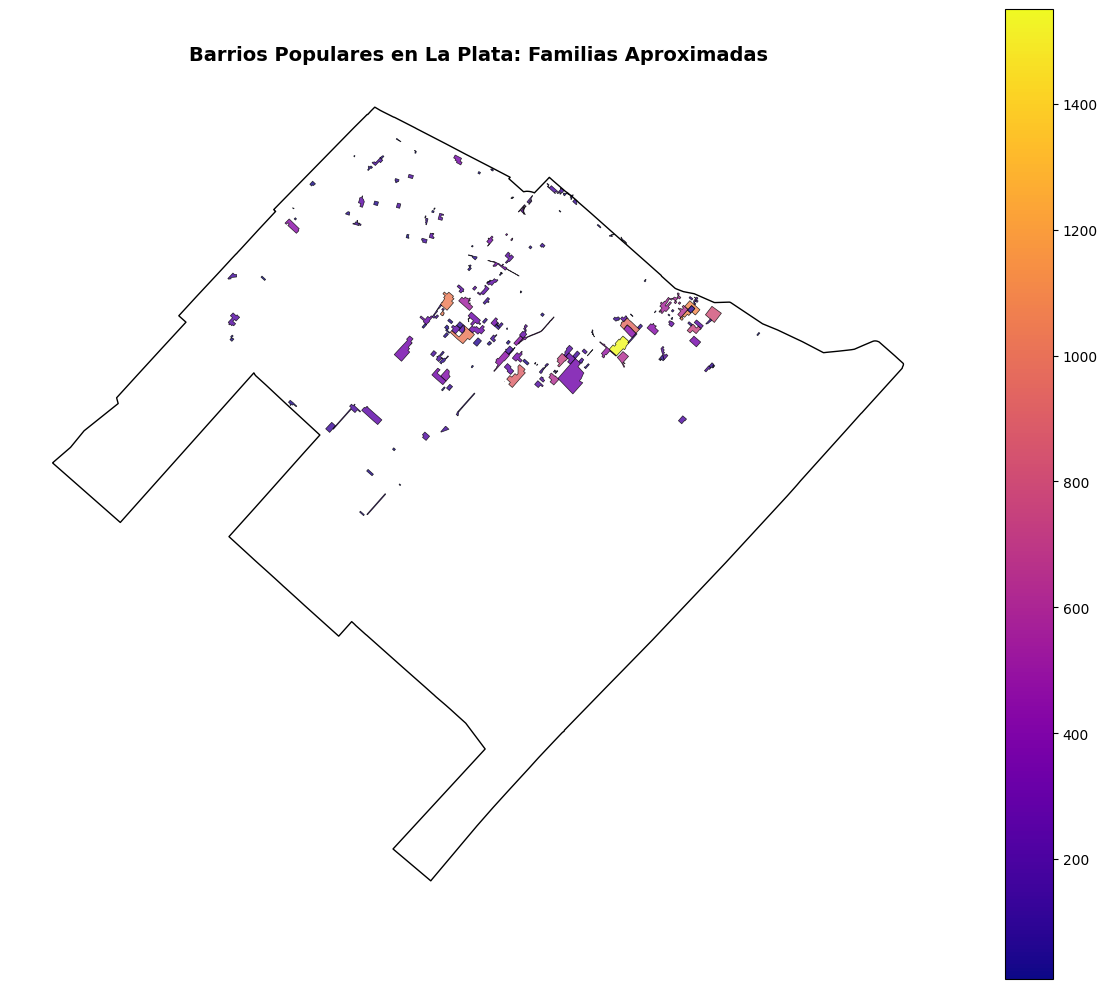

In [103]:
fig, ax = plt.subplots(figsize=(12, 10))

renabap_la_plata.plot('familias_aproximadas', ax=ax, legend=True, cmap='plasma', 
                       edgecolor='black', linewidth=0.5, alpha=0.8)

la_plata.boundary.plot(ax=ax, color='black', linewidth=1)

# Add title
ax.set_title('Barrios Populares en La Plata: Familias Aproximadas', 
             fontsize=14, fontweight='bold')

# Remove axes
ax.set_axis_off()

plt.tight_layout()
plt.show()

Now that we've filtered for La Plata, we can start to do some more meaningful descriptive statistics. Again, we'll look at the _distribution_ of estimated population across informal settlements _in the La Plata area only_. 

In [15]:
renabap_la_plata['familias_aproximadas'].describe()

count     167.000000
mean      203.131737
std       238.285607
min         9.000000
25%        46.000000
50%       132.000000
75%       252.000000
max      1551.000000
Name: familias_aproximadas, dtype: float64

A histogram can help us get a better sense of the distribution. [Add a definition of a histogram.]

array([[<Axes: title={'center': 'familias_aproximadas'}>]], dtype=object)

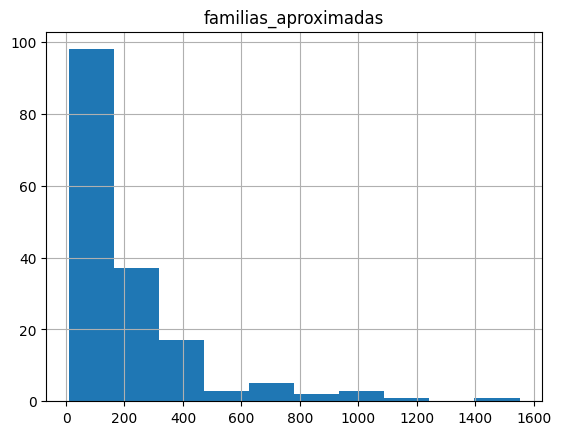

In [16]:
renabap_la_plata.hist('familias_aproximadas')

We can also plot the name of the largest and smallest barrios.

In [106]:
# TODO: print the name of the largest and smallest barrios based on the 'familias_aproximadas' column
# Find largest barrio by family count
largest = renabap_la_plata.loc[renabap_la_plata['familias_aproximadas'].idxmax()]
print(f"Barrio más grande: {largest['nombre_barrio']} ({largest['familias_aproximadas']} familias)")

# Find smallest barrio by family count
smallest = renabap_la_plata.loc[renabap_la_plata['familias_aproximadas'].idxmin()]
print(f"Barrio más pequeño: {smallest['nombre_barrio']} ({smallest['familias_aproximadas']} familias)")

Barrio más grande: Puente de Fierro (1551 familias)
Barrio más pequeño: La Hermosura (9 familias)


Now we have a good sense of what's in the RENABAP data. However, as we recall, the methdology used to produce the data gives us reason to believe these data may not be super accurate. Next, we'll turn to a global population dataset as our first point of comparison.

### 1.2 Datos GHSL

Several global datasets exist that can give us insight into population patterns. Some of the ones commonly used in climate risk analysis include the Global Human Settlement Layer (GHSL), WorldPop, and the High Resolution settlement layer. These datasets are typically derived from a combination of satellite imagery and ancillary data, such as global buildings and roads or nighttime lights, and are estimated using machine learning models. Each of these datasets has advantages and limitations: some have higher resolutions or more temporal coverage or better methodological consistency. Here, we'll use GHSL because it was the dataset with the highest resolution and best temporal coverage available at the time of writing, along with being the dataset of choice for Floodbase, a global flood risk company [@tellman2021].

La [Capa Global de Asentamientos Humanos (Global Human Settlement Layer)](https://human-settlement.emergency.copernicus.eu/ghs_pop2023.php) [@ghsl_pop2023a] es un conjunto de datos de resolución de 100 metros que proporciona estimaciones de población multitemporales (1975-2030) derivadas de datos censales y administrativos, informadas por la distribución y clasificación de áreas construidas. Para este análisis se utilizan los datos GHSL de 2023, que son los más recientes disponibles y los más cercanos temporalmente al Censo Argentino 2022. El GHSL ya tiene un uso científico establecido para mapear la exposición poblacional a peligros de inundación [@tellman2021]. Sin embargo, esta fuente presenta limitaciones importantes: estudios sobre modelado de riesgo de inundación con conjuntos de datos globales han demostrado que evaluar la exposición a esta escala de resolución puede llevar a sobreestimaciones de la exposición poblacional en zonas de peligro de inundación en comparación con datos de mayor resolución [@smith2019].

Here, we'll import GHSL data from a cloud-optimized GeoTIFF, which is a file format designed for efficient access of remotely-stored datasets. For our purposes, this means it's easy to load directly without using a ton of memory or having to download a local file.

In [111]:
renabap_la_plata.total_bounds.plot()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [112]:
# Import GHSL population data
ghsl_ruta = "/home/nissim/Downloads/spatial/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R14_C13/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R14_C13.tif"

# use chunking and lazy loading to avoid loading the entire dataset into memory
ghsl = rio.open_rasterio(
    ghsl_ruta,
    chunks={"x": 2048, "y": 2048},
)

# Reproject to USE_CRS
ghsl = ghsl.rio.reproject(dst_crs=USE_CRS)

We recall that there are some informal settlements that _do not fall completely within the official boundaries of the Partido._ Therefore, if we simply _clip_ the GHSL data to the boundaries of La Plata, we will actually be cutting out population that should be counted as part of the informal settlements! To address this, we'll clip by the _bounding box_ of the informal settlements. 

In [115]:
# Clip to the total bounds of the informal settlements
bounds = renabap_la_plata.total_bounds
ghsl_clipped = ghsl.rio.clip_box(
    minx=bounds[0],
    miny=bounds[1],
    maxx=bounds[2],
    maxy=bounds[3],
)

# Properly handle no-data values (-200) while keeping xarray structure
ghsl_clipped = ghsl_clipped.where(ghsl_clipped > -200)

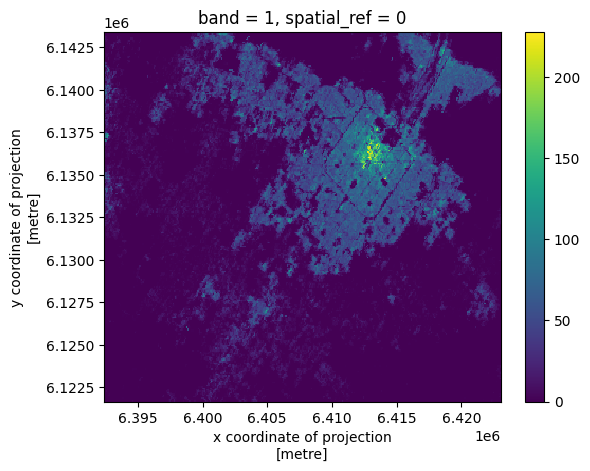

In [116]:
ghsl_clipped.plot()

In [25]:
import rasterstats

We can use GHSL population data to estimate the population of informal settlements. We do this by using zonal statistics, a technique we saw in the previous workshop.

One quirk of zonal statistics is the way they handle cells that are _partially_ within the area of interest. Here, we'll calculate it both ways: _including_ these cells and _excluding_ them in order to compare the results of both approaches.

In [87]:
# Set no-data values to 0, keep all valid population values
ghsl_final = ghsl_clipped.where(ghsl_clipped > -200, 0)

# Extract geometries for zonal statistics
barrio_geometries = [geom for geom in renabap_la_plata.geometry]

# Calculate zonal statistics for GHSL population (high estimate - all touched)
ghsl_stats_alta = rasterstats.zonal_stats(
    barrio_geometries,
    ghsl_final.values[0],
    affine=ghsl_final.rio.transform(),
    stats=["sum"],
    nodata=0,
    all_touched=True
)

# Calculate zonal statistics for GHSL population (low estimate - only center)
ghsl_stats_baja = rasterstats.zonal_stats(
    barrio_geometries,
    ghsl_final.values[0],
    affine=ghsl_final.rio.transform(),
    stats=["sum"],
    nodata=0,
    all_touched=False
)

# Add both GHSL population estimates to renabap_la_plata
ghsl_sums_alta = [stat["sum"] if stat["sum"] is not None else 0 for stat in ghsl_stats_alta]
ghsl_sums_baja = [stat["sum"] if stat["sum"] is not None else 0 for stat in ghsl_stats_baja]

renabap_la_plata["ghsl_pop_est_alta"] = ghsl_sums_alta
renabap_la_plata["ghsl_pop_est_baja"] = ghsl_sums_baja

In [89]:
print(renabap_la_plata["ghsl_pop_est_alta"].sum())
print(renabap_la_plata["ghsl_pop_est_baja"].sum())

151250.4657545397
89082.94773741066


In [91]:
print(renabap_la_plata["ghsl_pop_est_alta"].describe())

count     167.000000
mean      905.691412
std      1034.963665
min         0.000000
25%       228.593756
50%       553.785965
75%      1258.653251
max      5237.717794
Name: ghsl_pop_est_alta, dtype: float64


array([[<Axes: title={'center': 'ghsl_pop_est_alta'}>]], dtype=object)

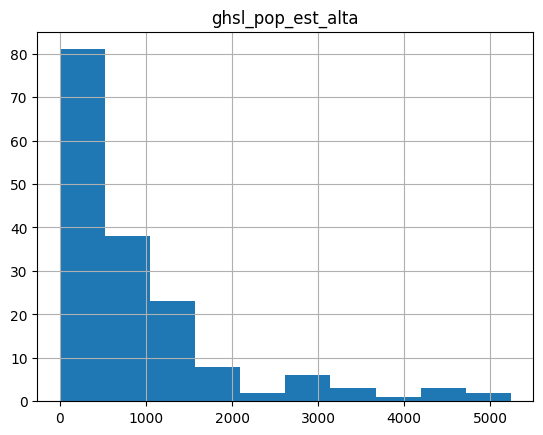

In [94]:
renabap_la_plata.hist('ghsl_pop_est_alta')

In [92]:
print(renabap_la_plata["ghsl_pop_est_baja"].describe())

count     167.000000
mean      533.430825
std       762.901664
min         0.000000
25%        81.442774
50%       252.472338
75%       731.548264
max      4347.947598
Name: ghsl_pop_est_baja, dtype: float64


array([[<Axes: title={'center': 'ghsl_pop_est_baja'}>]], dtype=object)

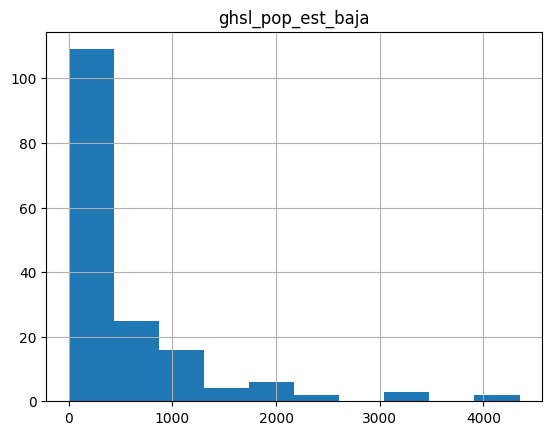

In [95]:
renabap_la_plata.hist('ghsl_pop_est_baja')

We can now compare these data to the RENABAP population estimates. Here, it's important to bear in mind that RENABAP reports _families_, while GHSL reports _population_. Thus, while we expect these numbers to be _proportional_ to one another, we would expect GHSL's estimates to be higher (probably about 3x higher, assuming roughly 3 people per family).

In [90]:
print(renabap_la_plata["ghsl_pop_est_alta"].sum() / renabap_la_plata["familias_aproximadas"].sum())
print(renabap_la_plata["ghsl_pop_est_baja"].sum() / renabap_la_plata["familias_aproximadas"].sum())

4.458640620067202
2.6260338925628823


One tool that we can use here is calculation the _correlation coefficient_, which measures the strength of the relationship between these two variables. These values range from 0 to 1, with those closer to 1 indicating a strong relationship. The p-value indicates how confident we are in the significance of these relationships (we're looking for p-values of 0.05 or lower). Here, we're using Spearman's correlation coefficient (rather than Pearson's) because it's better suited to messy data.

In this case, we see that both GHSL columns have _strong_ correlations with the RENABAP data, indicating that they are closely related. This does _not_ mean that they agree on the actual number of people per barrio, but that [what does this actually mean]?

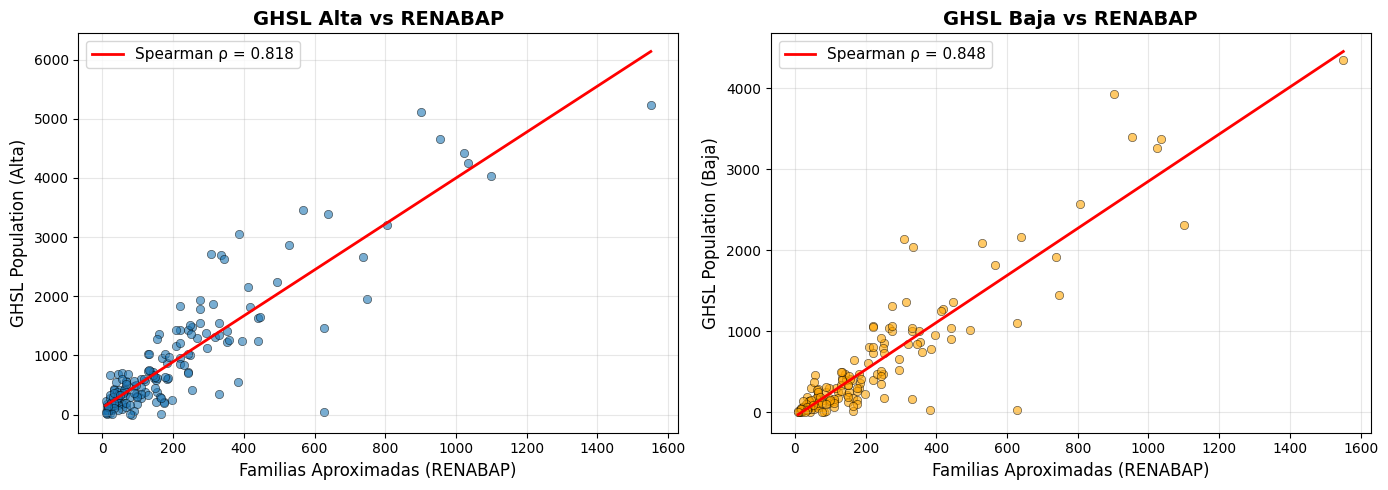

GHSL Alta vs RENABAP Familias:
  Spearman ρ = 0.8177
  p-value = 2.01e-41

GHSL Baja vs RENABAP Familias:
  Spearman ρ = 0.8475
  p-value = 2.93e-47


In [96]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: GHSL Alta vs RENABAP Families
ax1 = axes[0]
ax1.scatter(renabap_la_plata['familias_aproximadas'], 
            renabap_la_plata['ghsl_pop_est_alta'],
            alpha=0.6, edgecolors='k', linewidth=0.5)

# Spearman correlation for GHSL alta vs families
rho1, p_value1 = stats.spearmanr(
    renabap_la_plata['familias_aproximadas'], 
    renabap_la_plata['ghsl_pop_est_alta']
)

# Add regression line for reference
slope1, intercept1 = np.polyfit(
    renabap_la_plata['familias_aproximadas'], 
    renabap_la_plata['ghsl_pop_est_alta'], 
    1
)
x1 = np.array([renabap_la_plata['familias_aproximadas'].min(), 
               renabap_la_plata['familias_aproximadas'].max()])
ax1.plot(x1, intercept1 + slope1*x1, 'r-', linewidth=2, 
         label=f'Spearman ρ = {rho1:.3f}')

ax1.set_xlabel('Familias Aproximadas (RENABAP)', fontsize=12)
ax1.set_ylabel('GHSL Population (Alta)', fontsize=12)
ax1.set_title('GHSL Alta vs RENABAP', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Plot 2: GHSL Baja vs RENABAP Families
ax2 = axes[1]
ax2.scatter(renabap_la_plata['familias_aproximadas'], 
            renabap_la_plata['ghsl_pop_est_baja'],
            alpha=0.6, edgecolors='k', linewidth=0.5, color='orange')

# Spearman correlation for GHSL baja vs families
rho2, p_value2 = stats.spearmanr(
    renabap_la_plata['familias_aproximadas'], 
    renabap_la_plata['ghsl_pop_est_baja']
)

# Add regression line for reference
slope2, intercept2 = np.polyfit(
    renabap_la_plata['familias_aproximadas'], 
    renabap_la_plata['ghsl_pop_est_baja'], 
    1
)
x2 = np.array([renabap_la_plata['familias_aproximadas'].min(), 
               renabap_la_plata['familias_aproximadas'].max()])
ax2.plot(x2, intercept2 + slope2*x2, 'r-', linewidth=2, 
         label=f'Spearman ρ = {rho2:.3f}')

ax2.set_xlabel('Familias Aproximadas (RENABAP)', fontsize=12)
ax2.set_ylabel('GHSL Population (Baja)', fontsize=12)
ax2.set_title('GHSL Baja vs RENABAP', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed stats
print(f"GHSL Alta vs RENABAP Familias:")
print(f"  Spearman ρ = {rho1:.4f}")
print(f"  p-value = {p_value1:.2e}\n")

print(f"GHSL Baja vs RENABAP Familias:")
print(f"  Spearman ρ = {rho2:.4f}")
print(f"  p-value = {p_value2:.2e}")



Now who else should notice there are some strong outliers.

There are several neighborhoods where the population difference is really big.

We can actually estimate the population, we sort of take this average and multiply by families.

We can actually estimate the difference in population estimates between the two of them.

So we can kind of highlight some of these audios where there's the biggest disagreement between our two data sets.

And sort of say these are probably worth looking into.

Again, it's important to note that we need to look at percent disagreement, not just total disagreement, because I disagree with three families in a row with 5,000 families is less important than the disagreement of 50 families.

The disagreement of 50 families in a row of 4,000 families is less important than a disagreement of 50 families in a row of 500 families.

So we can do the percent disagreement between them two.

We can also now pass to, so we can sort of highlight these neighborhoods that have kind of big discrepancies here.

But generally, these two data seem to suggest roughly similar number of population.

So the RENABAP and GHSL data generally agree on roughly the number of people per barrio, which should give us some confidence in the data. However, we're now going to look at a third dataset that should raise some major doubts.

### 1.3 Datos de edificaciones

Los datos de [Google-Microsoft-OSM Open Buildings](https://source.coop/repositories/vida/google-microsoft-osm-open-buildings/access) [@google_microsoft_osm_buildings] brindan una herramienta más precisa para identificar la ubicación de los asentamientos humanos. Este conjunto integra huellas edilicias provenientes de Google V3 Open Buildings, Microsoft GlobalMLFootprints, y OpenStreetMap building footprints, conteniendo más de 2.7 mil millones de edificaciones georreferenciadas.

Estos datos han sido utilizados en evaluaciones de riesgo de inundación por [empresas globales de riesgo financiero, como ICE](https://www.ice.com/insights/sustainable-finance/ice-climates-exposure-datasets-understanding-how-climate-risks-impact-infrastructure-and-communities), demostrando su utilidad para mapear la exposición climática a nivel de huella individual. Su resolución espacial permite estimar con mayor detalle la distribución de las estructuras habitacionales en el área analizada.

Sin embargo, en ausencia de información sobre el uso específico de cada edificación (residencial, comercial, institucional), y sin datos sobre el número de unidades habitacionales ni de habitantes por edificio, las estimaciones poblacionales que podemos obtener de estas huellas son necesariamente aproximadas. Podemos inferir patrones de ocupación espacial, pero no acceder a una comprensión precisa sobre quién vive allí ni cuántas personas habitan cada estructura.

A third (and very new) source of population estimates is global building footprints data. Building footprints are [give a definition]. On one hand, they have a nice benefit of being very clear: either there is a building or there isn't, and it's usually pretty easy to check in a satellite basemap. So these are fairly reliable data.

However, one obstacle to estimating population based on building footprints alone is that buildings come in many different types and sizes: some have one floor and some have seven or fifteen of forty, and some are residential and some are commercial and some are industrial, none of which you would know from a footprint alone.

But informal settlements are kind of unique in this respect. They tend not to have a lot of formal commercial buildings, and few (if any) multi-story buildings. It's generally safe to assume that--for the most part--informal settlements have roughly one family per building. This was something I also confirmed in conversations with municipal GIS officials here in La Plata, just to be safe. So, in our analysis of building footprints in informal settlements in La Plata, we _expect_ the number of building footprints to more or less match the number of families estimated by RENABAP.

Several global building footprint datasets exist, e.g., from Google, Microsoft, and OSM. The dataset we'll be using is from VIDA, a climate tech company, which has published the data in an open source format on Source Cooperative [include link] along with lots of documentation. [Look into these docs.]

We're going to use a tool called DuckDB to pull these in. DuckDB is a kind of database tool that allows us to very efficiently process massive datasets in-memory. For our purposes, what this means is that we can process a lot of data very efficiently. We're specifically going to do this using a spatial query, which will check for the buildings that fall within our area of interest. Filtering the dataset _before_ running our spatial aggregation will dramatically speed up the processing by reducing the total amount of data that has to be processed. In general, focusing on smart processing approaches--rather than just using the newest, fanciest tech tools--is where you'll gain the most efficiency.

In [80]:
# talk about the geoparquet bit

In [ ]:
# add spatial processing code

Before we do anything with these building footprints, we're going to do a bit of pre-processing. We want to eliminate buildings that are _too small_ to plausibly be homes (e.g., sheds, storage units, etc.). There's not a precise size for this, and informal settlements tend to have smaller than average housing units, but we're going to go with 15m² for our purposes. You could adjust this number based on local knowledge.

Now, our spatial processing here is called _spatial aggregation_. All we're doing is _joining_ the buildings to informal settlements--any building that falls _within_ a barrio will get the columns of that barrio--and then summing the total number of buildings per barrio. We'll add those sums back to the original barrios data so that our resulting dataset is the original barrios _plus_ the number of buildings (greater than 15m²) per barrio.

In [81]:
# do that

We can now do the same descriptive statistics as before. When we do, we're going to notice something really interesting: while the _correlation_ between RENABAP estimates and building footprints is really strong, there's a really big difference between the _total number of esimated families_ per barrio, assuming each building footprint corresponds to one family.

We can map a couple of our outliers here, comparing the number of families estimated by RENABAP and the number of building footprints. Clearly, they don't line up.

In [ ]:
# map

So this raises some big questions about the reliability of the official RENABAP estimates. It looks like they tend to underestimate the population per settlement by a factor of almost two! Which means that, if we assume an average family size around 3, we could be talking about 100,000 or more people not accounted for in official data.

So what would we do with this information? Well, real action would require us to go out and do more validation of these data. And there should probably be scientific studies done to further understand what's going on. But this shows us the power of these data!

We actually would need to really establish this uncertainty. We would actually need to go out and visit some of these informal settlements and get a sense of how accurate the buildings of prints are.

We would need to do a better census of the informal settlements, which obviously is outside the scope of the study.

In [29]:
BASE_PATH = "/home/nissim/Documents/dev/fulbright/ciut-riesgo"
BUILDINGS_PATH = f"{BASE_PATH}/notebooks/buildings_filtered.parquet"

In [30]:
import sys
print(sys.executable)

/home/nissim/Documents/dev/datos-escala-humana/.venv/bin/python


In [31]:
# if os.path.exists(BUILDINGS_PATH):
#     buildings = gpd.read_parquet(BUILDINGS_PATH)
# else:
#     buildings = fetch_buildings(la_plata.buffer(500))

buildings = gpd.read_parquet(BUILDINGS_PATH)

la_plata_buffered = la_plata.union_all().buffer(500)
buildings_proj = buildings.to_crs(USE_CRS)
buildings_proj = buildings_proj[buildings_proj.geometry.intersects(la_plata_buffered)]

In [32]:
buildings_proj.shape

(650812, 10)

In [33]:
buildings_filtered = buildings_proj[buildings_proj['area_in_meters'] > 15] # filter out really small buildings

In [34]:
buildings_filtered.shape

(601283, 10)

In [35]:
# =============================================================================
# SPATIAL INTERSECTION: Sum buildings per barrio popular
# =============================================================================

# Perform spatial join to find which buildings intersect with each barrio
buildings_in_barrios = gpd.sjoin(
   buildings_filtered,  # Use filtered buildings
    renabap_la_plata[["id_renabap", "geometry"]], 
    how="inner", 
    predicate="within"
)

# Count buildings per barrio
buildings_per_barrio = buildings_in_barrios.groupby("id_renabap").size().reset_index(name="buildings_count")

# Merge back to renabap_la_plata
renabap_la_plata = renabap_la_plata.merge(
    buildings_per_barrio, 
    on="id_renabap", 
    how="left"
)

# Fill NaN values with 0 for barrios with no buildings
renabap_la_plata["buildings_count"] = renabap_la_plata["buildings_count"].fillna(0).astype(int)


In [36]:
renabap_la_plata.describe()


,id_renabap,familias_aproximadas,ghsl_population_sum,buildings_count
count,167.000000,167.000000,167.000000,167.000000
mean,1185.185629,203.131737,533.430825,384.047904
std,1765.065218,238.285607,762.901664,507.250809
min,2.000000,9.000000,0.000000,9.000000
25%,69.000000,46.000000,81.442774,84.000000
50%,627.000000,132.000000,252.472338,212.000000
75%,1075.500000,252.000000,731.548264,480.500000
max,6545.000000,1551.000000,4347.947598,3175.000000


### 1.4 Comparación de datos

Compare estimated families and GHSL pop to building count. takeaways are:

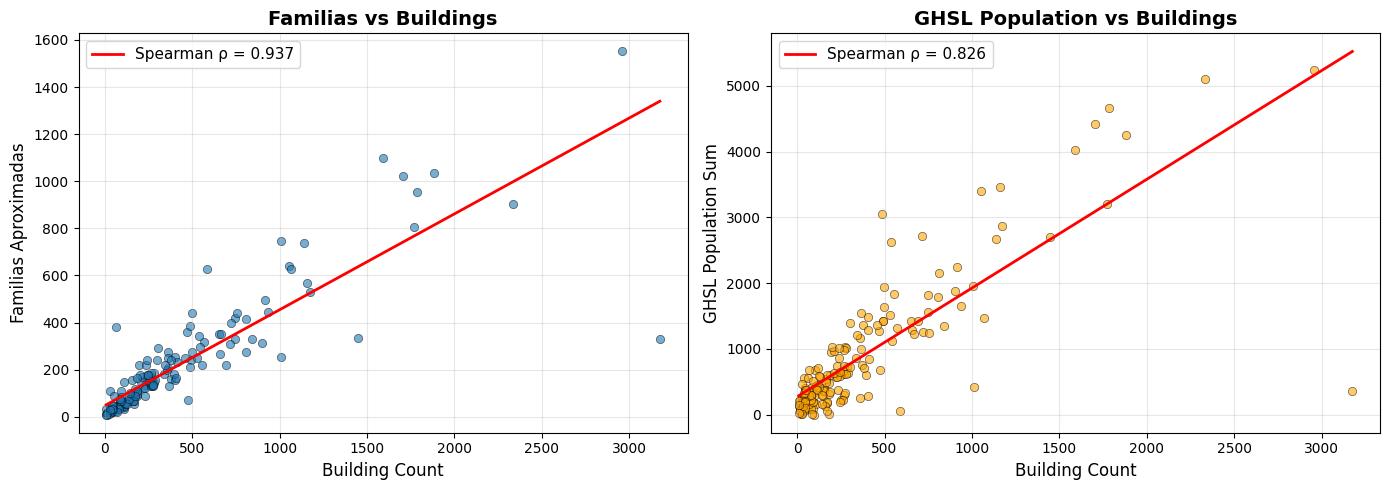

Familias vs Buildings:
  Spearman ρ = 0.9368
  p-value = 3.80e-77

GHSL Population vs Buildings:
  Spearman ρ = 0.8260
  p-value = 6.12e-43


In [85]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Families vs Buildings
ax1 = axes[0]
ax1.scatter(renabap_la_plata['buildings_count'], 
            renabap_la_plata['familias_aproximadas'],
            alpha=0.6, edgecolors='k', linewidth=0.5)

# Spearman correlation for families vs buildings
rho1, p_value1 = stats.spearmanr(
    renabap_la_plata['buildings_count'], 
    renabap_la_plata['familias_aproximadas']
)

# Add regression line for reference (still linear)
slope1, intercept1 = np.polyfit(
    renabap_la_plata['buildings_count'], 
    renabap_la_plata['familias_aproximadas'], 
    1
)
x1 = np.array([renabap_la_plata['buildings_count'].min(), 
               renabap_la_plata['buildings_count'].max()])
ax1.plot(x1, intercept1 + slope1*x1, 'r-', linewidth=2, 
         label=f'Spearman ρ = {rho1:.3f}')

ax1.set_xlabel('Building Count', fontsize=12)
ax1.set_ylabel('Familias Aproximadas', fontsize=12)
ax1.set_title('Familias vs Buildings', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Plot 2: GHSL Population vs Buildings
ax2 = axes[1]
ax2.scatter(renabap_la_plata['buildings_count'], 
            renabap_la_plata['ghsl_population_sum'],
            alpha=0.6, edgecolors='k', linewidth=0.5, color='orange')

# Spearman correlation for GHSL vs buildings
rho2, p_value2 = stats.spearmanr(
    renabap_la_plata['buildings_count'], 
    renabap_la_plata['ghsl_population_sum']
)

# Add regression line for reference
slope2, intercept2 = np.polyfit(
    renabap_la_plata['buildings_count'], 
    renabap_la_plata['ghsl_population_sum'], 
    1
)
x2 = np.array([renabap_la_plata['buildings_count'].min(), 
               renabap_la_plata['buildings_count'].max()])
ax2.plot(x2, intercept2 + slope2*x2, 'r-', linewidth=2, 
         label=f'Spearman ρ = {rho2:.3f}')

ax2.set_xlabel('Building Count', fontsize=12)
ax2.set_ylabel('GHSL Population Sum', fontsize=12)
ax2.set_title('GHSL Population vs Buildings', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed stats
print(f"Familias vs Buildings:")
print(f"  Spearman ρ = {rho1:.4f}")
print(f"  p-value = {p_value1:.2e}\n")

print(f"GHSL Population vs Buildings:")
print(f"  Spearman ρ = {rho2:.4f}")
print(f"  p-value = {p_value2:.2e}")

In [38]:
print(renabap_la_plata['familias_aproximadas'].sum())

33923


In [86]:
print(renabap_la_plata['ghsl_population_sum'].sum())

151250.4657545397


In [40]:
print(renabap_la_plata['buildings_count'].sum())

64136


count    167.000000
mean       1.829411
std        0.950827
min        0.169713
25%        1.369318
50%        1.765625
75%        2.084886
max        9.621212
Name: buildings_per_family, dtype: float64


<Axes: >

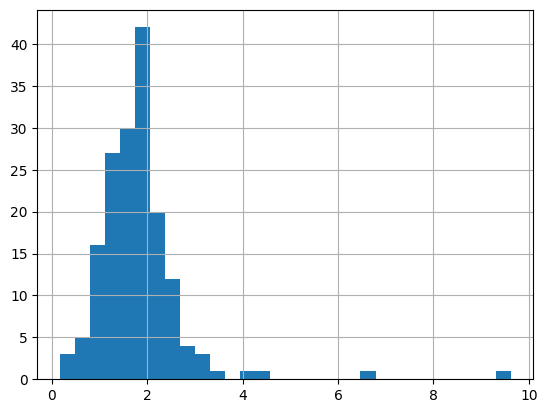

In [41]:
renabap_la_plata['buildings_per_family'] = (
    renabap_la_plata['buildings_count'] / renabap_la_plata['familias_aproximadas']
)

print(renabap_la_plata['buildings_per_family'].describe())
renabap_la_plata['buildings_per_family'].hist(bins=30)

## Sección 2: Peligro de inundaciones

In [ ]:
# datos de hidráulica
ruta_peligro = "/home/nissim/Documents/dev/fulbright/ciut-riesgo/notebooks/data/peligro_raster_10m.tif"
peligro_xarray = rio.open_rasterio(ruta_peligro)

# clip to la plata
# mask out 0 values (nodata/muy bajo peligro)

peligro_4326 = peligro_xarray.rio.reproject("EPSG:4326")


la_plata_4326 = la_plata.to_crs("EPSG:4326")
peligro_4326 = peligro_4326.rio.clip([la_plata_4326.union_all()], "EPSG:4326") # clip to la plata
peligro_4326 = peligro_4326.where(peligro_4326 != 0) # mask no data values

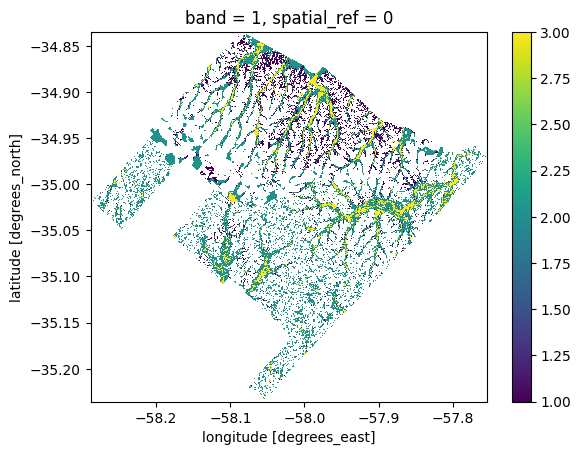

In [73]:
peligro_4326.plot()

In [43]:
# datos de HAND
hand_path = "/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/la_plata/final/hand-la-plata-100m.tif"
hand_xarray = rio.open_rasterio(hand_path)

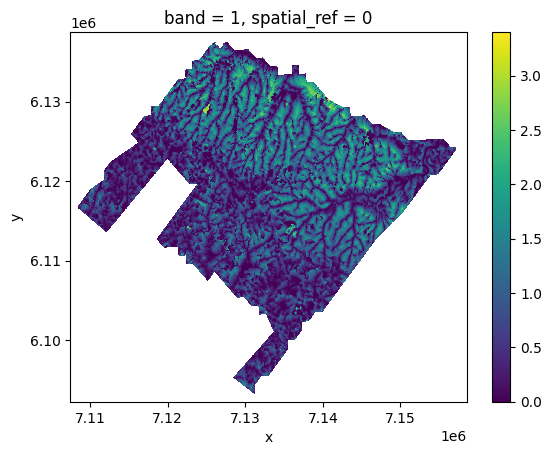

In [44]:
hand_xarray.plot()

In [47]:
hand_cat_xarray = hand_xarray.copy()
hand_cat_xarray.values = ((hand_xarray >= 0.5).astype(float) + 
                          (hand_xarray >= 2).astype(float) + 
                          (hand_xarray >= 5).astype(float))
hand_cat_xarray = hand_cat_xarray.where(hand_xarray.notnull())

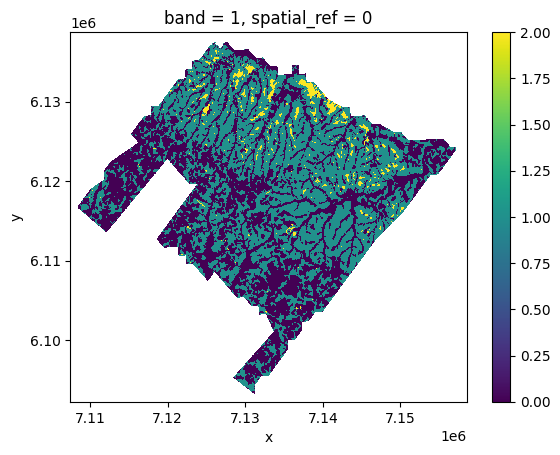

In [48]:
hand_cat_xarray.plot()

In [74]:
# datos de JRC
jrc_path = "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-GLOFAS/flood_hazard/RP100/ID85_S30_W60_RP100_depth.tif"
jrc_xarray = rio.open_rasterio(
    jrc_path,
    chunks={"x": 2048, "y": 2048},
)

la_plata_4326 = la_plata.to_crs("EPSG:4326")
jrc_xarray = jrc_xarray.rio.clip([la_plata_4326.union_all()], "EPSG:4326")
jrc_xarray_masked = jrc_xarray.where(jrc_xarray != jrc_xarray.rio.nodata)

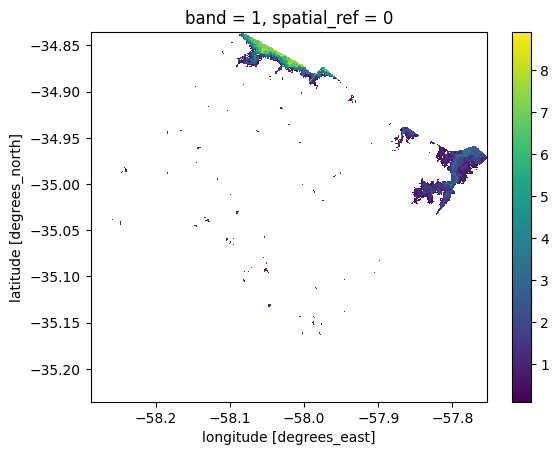

In [76]:
jrc_xarray_masked.plot()

/tmp/ipykernel_71595/1928156875.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis')



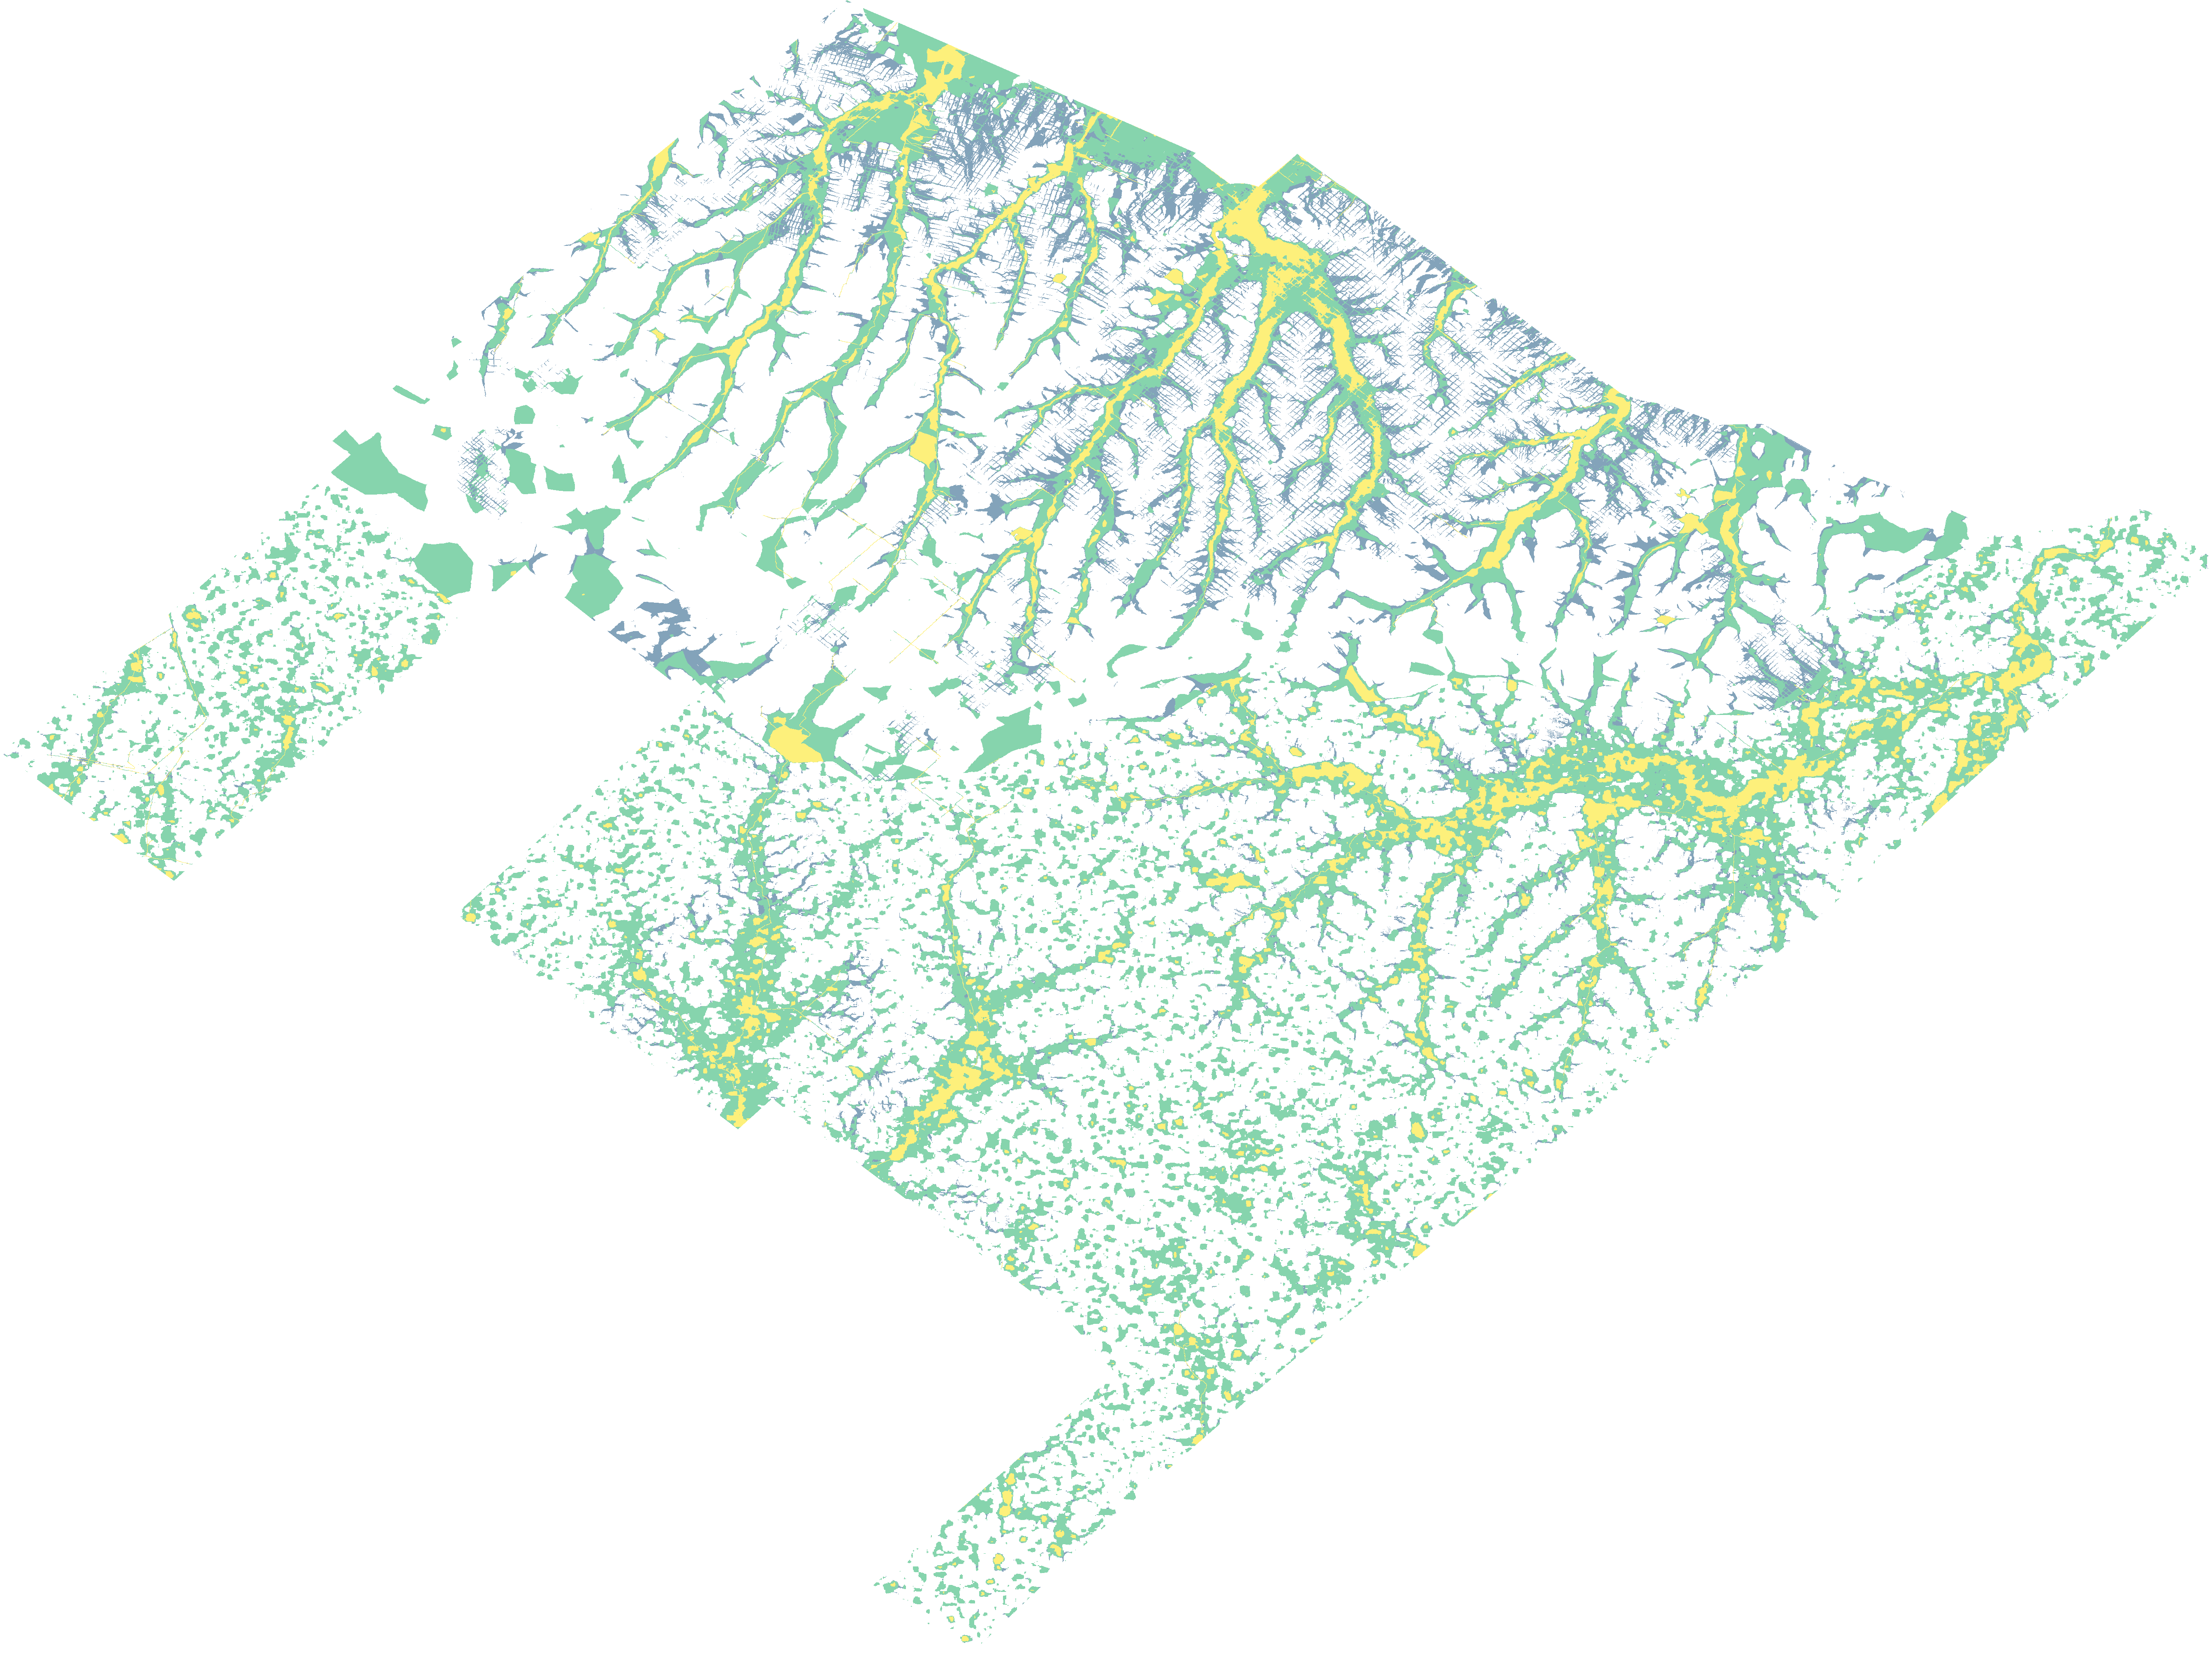
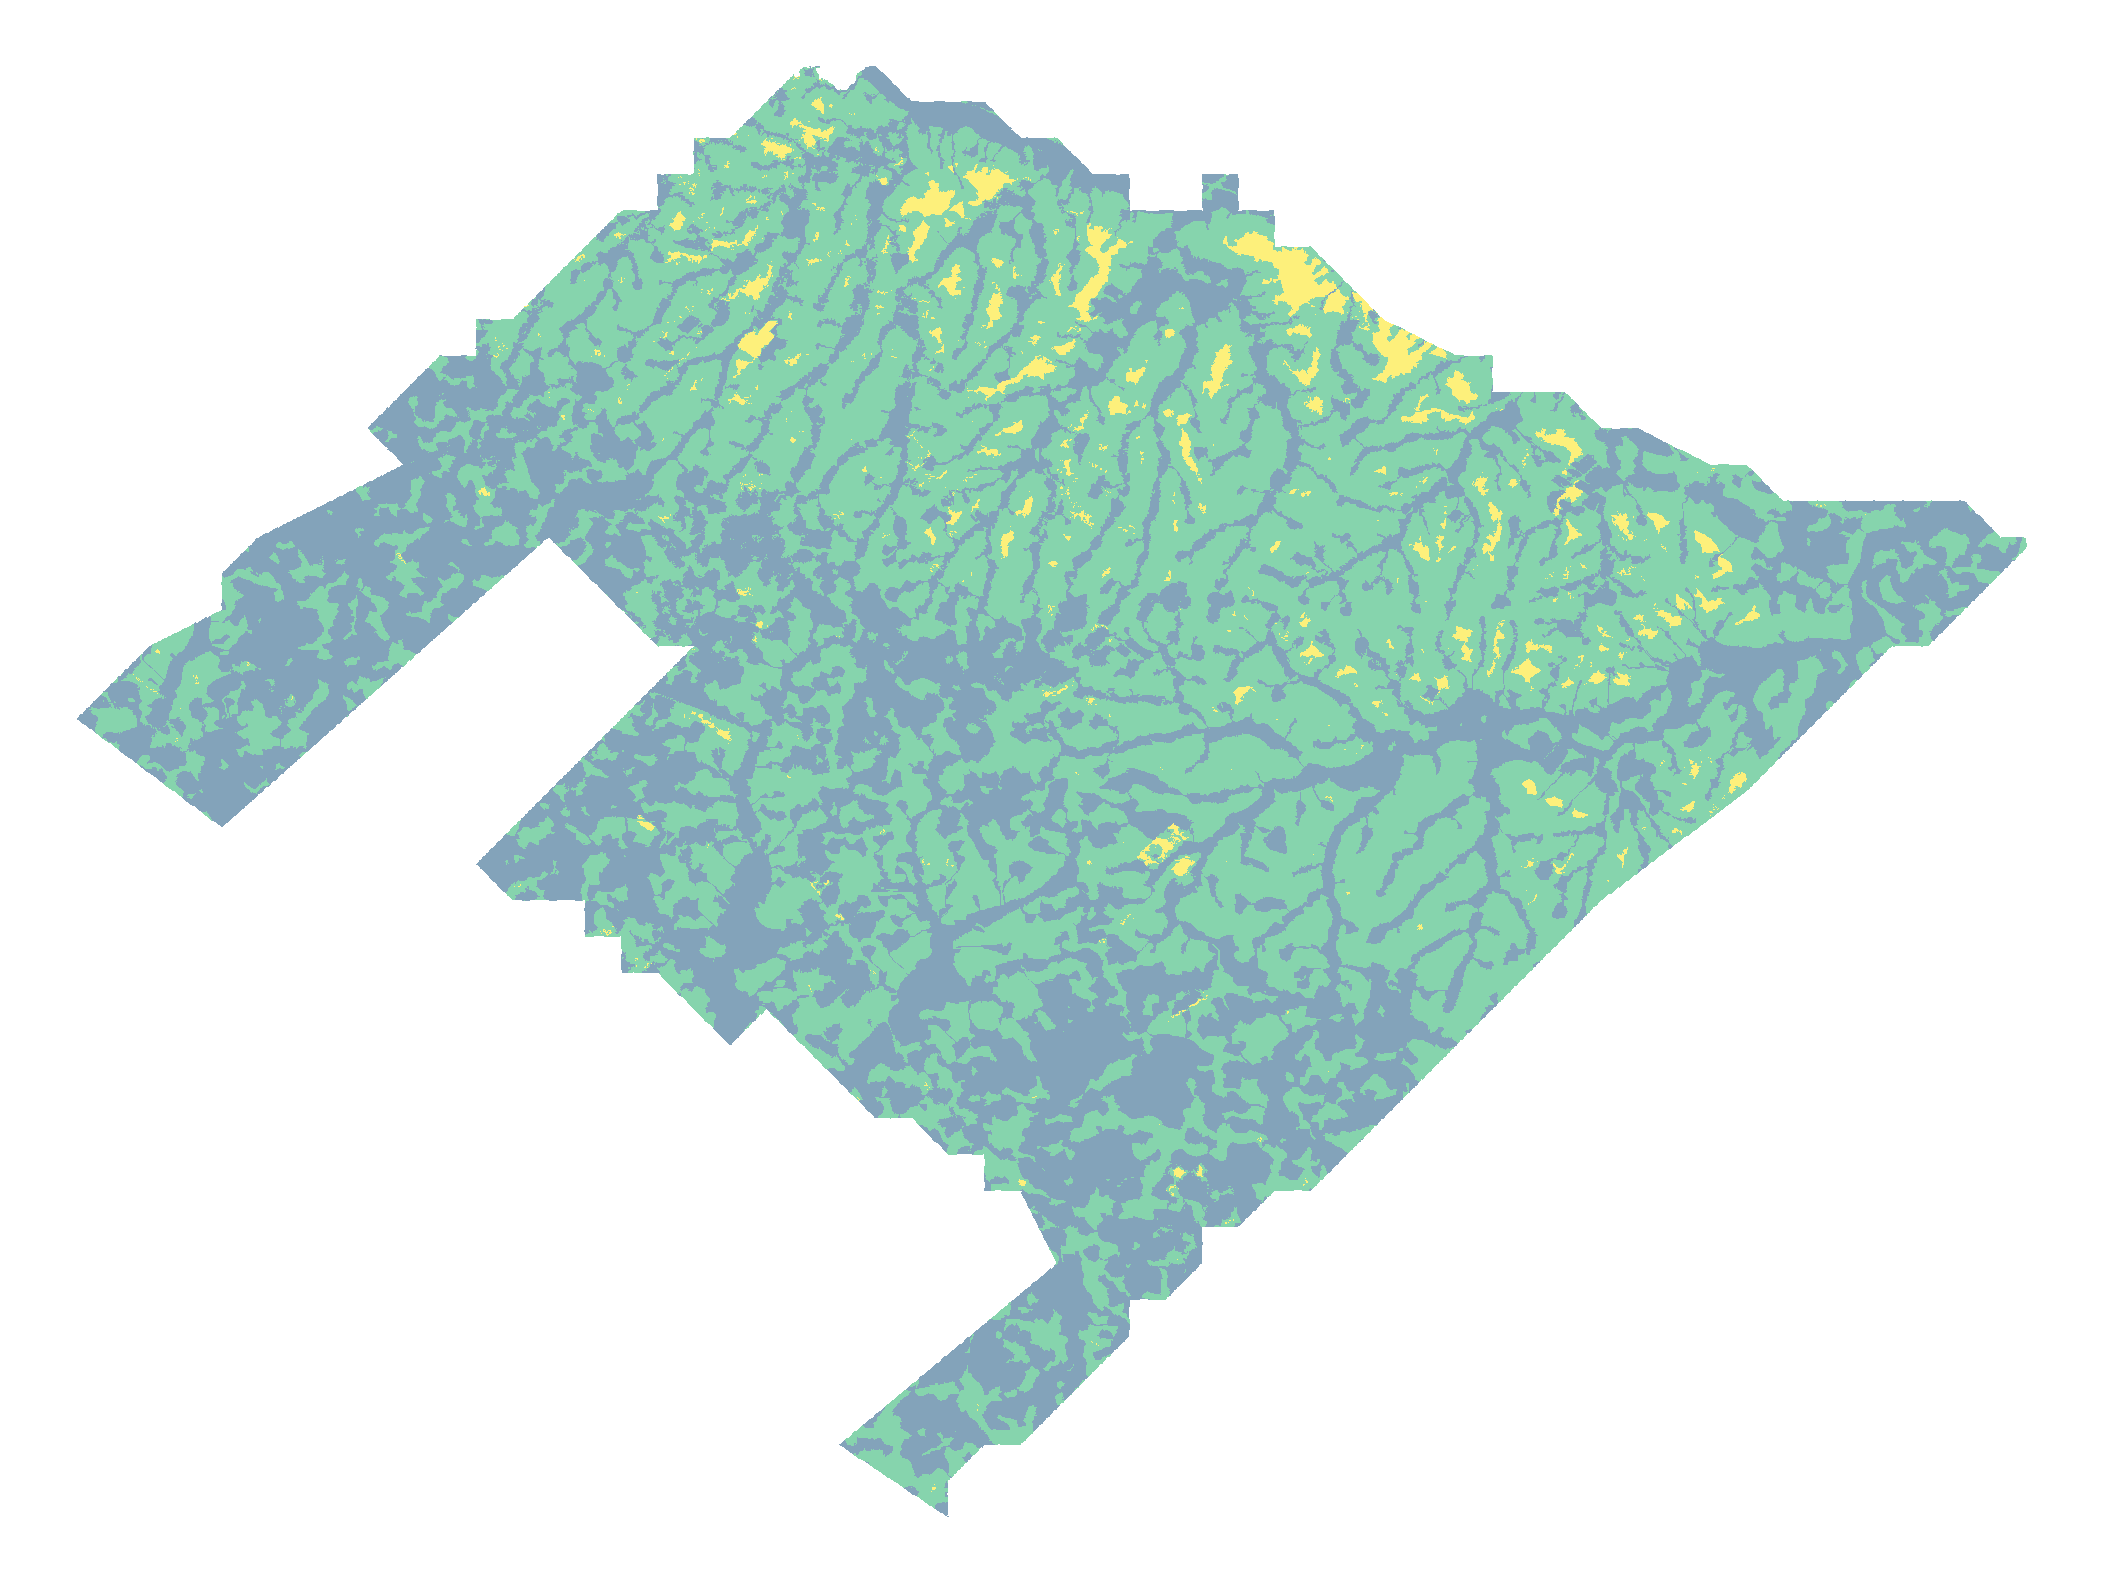

In [77]:
import folium
from folium import raster_layers
import numpy as np
from matplotlib import cm

# Create base map
m = folium.Map(
    location=[hand_cat_4326.y.mean().item(), hand_cat_4326.x.mean().item()],
    zoom_start=10,
    tiles='OpenStreetMap'
)

# Get viridis colors for indices 0-3
viridis = cm.get_cmap('viridis')
viridis_colors = (viridis(np.array([0, 0.33, 0.67, 1.0]))[:, :3] * 255).astype(np.uint8)

# Add Peligro layer (values: 0, 1, 2, 3 → colors: 0, 1, 2, 3)
peligro_data = peligro_4326.values.squeeze()
peligro_rgb = np.zeros((*peligro_data.shape, 4), dtype=np.uint8)

mask_0 = peligro_data == 0
mask_1 = peligro_data == 1
mask_2 = peligro_data == 2
mask_3 = peligro_data == 3

peligro_rgb[mask_0, :3] = viridis_colors[0]
peligro_rgb[mask_1, :3] = viridis_colors[1]
peligro_rgb[mask_2, :3] = viridis_colors[2]
peligro_rgb[mask_3, :3] = viridis_colors[3]
peligro_rgb[~np.isnan(peligro_data), 3] = 153

folium.raster_layers.ImageOverlay(
    image=peligro_rgb,
    bounds=[[peligro_4326.y.min().item(), peligro_4326.x.min().item()],
            [peligro_4326.y.max().item(), peligro_4326.x.max().item()]],
    opacity=0.8,
    name='Peligro'
).add_to(m)

# Add HAND layer (values: 0, 1, 2 → colors: 1, 2, 3)
hand_data = hand_cat_4326.values.squeeze()
hand_rgb = np.zeros((*hand_data.shape, 4), dtype=np.uint8)

hand_rgb[hand_data == 0, :3] = viridis_colors[1]  # Same as Peligro 1
hand_rgb[hand_data == 1, :3] = viridis_colors[2]  # Same as Peligro 2
hand_rgb[hand_data == 2, :3] = viridis_colors[3]  # Same as Peligro 3
hand_rgb[~np.isnan(hand_data), 3] = 153

folium.raster_layers.ImageOverlay(
    image=hand_rgb,
    bounds=[[hand_cat_4326.y.min().item(), hand_cat_4326.x.min().item()],
            [hand_cat_4326.y.max().item(), hand_cat_4326.x.max().item()]],
    opacity=0.8,
    name='HAND Categorizado'
).add_to(m)

folium.LayerControl().add_to(m)
m